<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/cancellations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
def convertTarget(df):
    df_copy = df.copy()
    cond = df_copy['reservation_status'] == 'No-Show'
    df_copy.loc[cond, 'reservation_status'] = 'Canceled'
    return df_copy
    

In [64]:
!pip install category_encoders==2.*
!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

import tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)
df = tools.fixTarget(df)
df = convertTarget(df)

X = df.drop('reservation_status', axis=1)
y= df['reservation_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.2,
                                                  random_state=42, stratify=y_train)

--2020-06-09 09:37:07--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8071 (7.9K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]   7.88K  --.-KB/s    in 0s      

2020-06-09 09:37:07 (84.0 MB/s) - ‘tools.py’ saved [8071/8071]



In [65]:
tools.wrangleData(max_cardinality=50).transform(X_train).head()


,hotel,lead_time,arrival_date_week_number,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,nights_stay
86334,City Hotel,44,14,1.0,0.0,0,BB,Online TA,TA/TO,0,0,0,D,G,1,No Deposit,0,Transient,104.40,0,1,1.0
89366,City Hotel,0,8,1.0,0.0,0,BB,Offline TA/TO,TA/TO,1,2,13,A,A,0,No Deposit,0,Transient,65.00,0,3,1.0
36805,Resort Hotel,38,21,2.0,0.0,0,BB,Direct,Direct,0,0,0,E,E,0,No Deposit,0,Transient,125.00,0,1,2.0
35490,Resort Hotel,2,16,1.0,0.0,0,BB,Direct,Direct,0,0,0,G,G,0,No Deposit,0,Transient,187.33,1,0,3.0
50066,City Hotel,142,17,2.0,0.0,0,BB,Groups,TA/TO,0,0,0,A,A,0,Non Refund,0,Transient,103.00,0,0,5.0


In [66]:
y_train.value_counts()

Check-Out    41697
Canceled     25161
Name: reservation_status, dtype: int64

In [0]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from sklearn.preprocessing import StandardScaler

In [0]:
y_train_enc = y_train == 'Canceled'

In [69]:
y_train.head()

86334    Check-Out
89366    Check-Out
36805    Check-Out
35490    Check-Out
50066     Canceled
Name: reservation_status, dtype: object

In [70]:
y_train_enc.head()

86334    False
89366    False
36805    False
35490    False
50066     True
Name: reservation_status, dtype: bool

In [0]:
pipe = make_pipeline(tools.wrangleData(max_cardinality=50),
                     ce.OrdinalEncoder(),
                     SimpleImputer(),
                     SelectKBest(score_func=chi2, k='all'))

pipe.fit(X_train, y_train_enc)

Pipeline(memory=None,
         steps=[('wrangledata',
                 wrangleData(max_cardinality=50, remove_dates=True)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['hotel', 'meal', 'market_segment',
                                      'distribution_channel',
                                      'reserved_room_type',
                                      'assigned_room_type', 'deposit_type',
                                      'customer_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'hote...
                                         {'col': 'customer_type',
                                          'data_type': dtype('O'),
                                          'mapping': Transient          1
Contract           2
Transient-Party    3
Group              4
NaN               -2
dtype: int64}],
               

In [0]:
scores = pd.Series(pipe.named_steps['selectkbest'].scores_, 
                   pipe.named_steps['wrangledata'].columns_)

scores.sort_values(ascending=False)

lead_time                         582626.324725
days_in_waiting_list               18787.629353
previous_cancellations              6104.345450
total_of_special_requests           3915.958923
previous_bookings_not_canceled      3790.607223
booking_changes                     2640.130997
required_car_parking_spaces         2467.158677
deposit_type                        1409.064243
assigned_room_type                  1287.141439
customer_type                        574.711918
distribution_channel                 390.642237
is_repeated_guest                    237.348662
hotel                                192.453417
market_segment                        87.576957
babies                                70.389153
arrival_date_week_number              32.329470
nights_stay                           31.094507
adults                                30.136481
children                               4.788557
reserved_room_type                     3.767487
meal                                   3

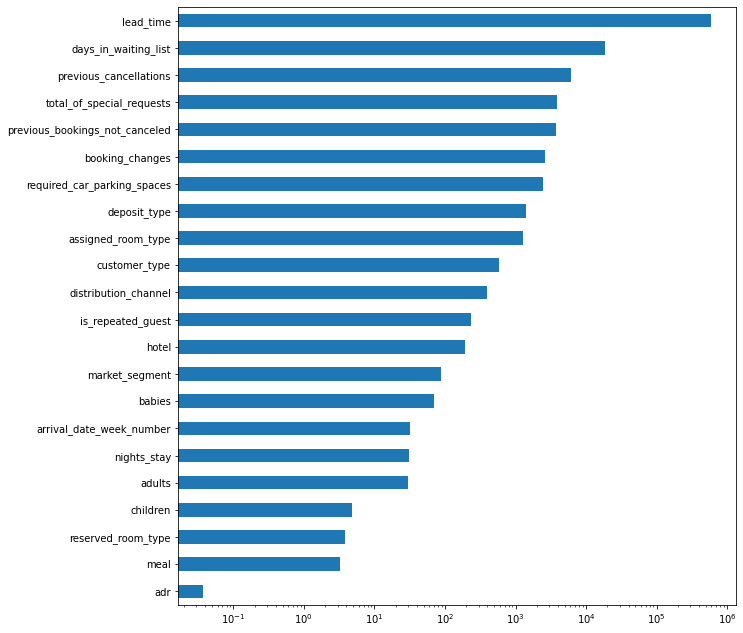

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, len(pipe.named_steps['wrangledata'].columns_) / 2))
scores.sort_values().plot.barh()
plt.xscale('log');

In [0]:
def getFeatures(scores, threshold):
    scores = scores.to_dict()
    features = []
    for key in scores:
        if scores[key] >= threshold:
          features.append(key)

    return features

In [0]:
log = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                    ce.OneHotEncoder(),
                    SimpleImputer(),
                    SMOTE(random_state=42),
                    LogisticRegression(max_iter=5000))

tools.tryModel(log, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 78.16416883544228 %
Validate score = 78.0676039485492 %




'Confusion Matrix'

,Check-Out,Canceled
Check-Out,8474,1951
Canceled,1715,4575


'Metrics'

,precision,recall,f1-score
Check-Out,0.831681,0.812854,0.822160
Canceled,0.701042,0.727345,0.713951


In [0]:


pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         SMOTE(random_state=42),
                         RandomForestClassifier(random_state=42,
                                                n_jobs=-1))

tools.tryModel(pipeline, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.24616351072422 %
Validate score = 85.88094525874963 %




'Confusion Matrix'

,Check-Out,Canceled
Check-Out,9508,917
Canceled,1443,4847


'Metrics'

,precision,recall,f1-score
Check-Out,0.868231,0.912038,0.889596
Canceled,0.840909,0.770588,0.804214


In [0]:
from sklearn.utils import compute_class_weight
weights = compute_class_weight('balanced', y_train.unique(), y_train)
weights

array([0.80171235, 1.32860379])

In [0]:
pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                         ce.OrdinalEncoder(),
                         SimpleImputer(),
                         SMOTE(random_state=42),
                         RandomForestClassifier(random_state=42,
                                                n_jobs=-1,
                                                class_weight={'Check-Out':weights[1],
                                                              'Canceled':weights[0]},
                                                max_depth=100))

tools.tryModel(pipeline, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.25214634000419 %
Validate score = 85.95871971283279 %




'Confusion Matrix'

,Check-Out,Canceled
Check-Out,9512,913
Canceled,1434,4856


'Metrics'

,precision,recall,f1-score
Check-Out,0.868993,0.912422,0.890178
Canceled,0.841740,0.772019,0.805374


In [0]:
from sklearn.metrics import precision_score, recall_score
y_pred = pipeline.predict(X_val)
precision_score(y_val, y_pred, pos_label='Canceled')

0.8417403362801179

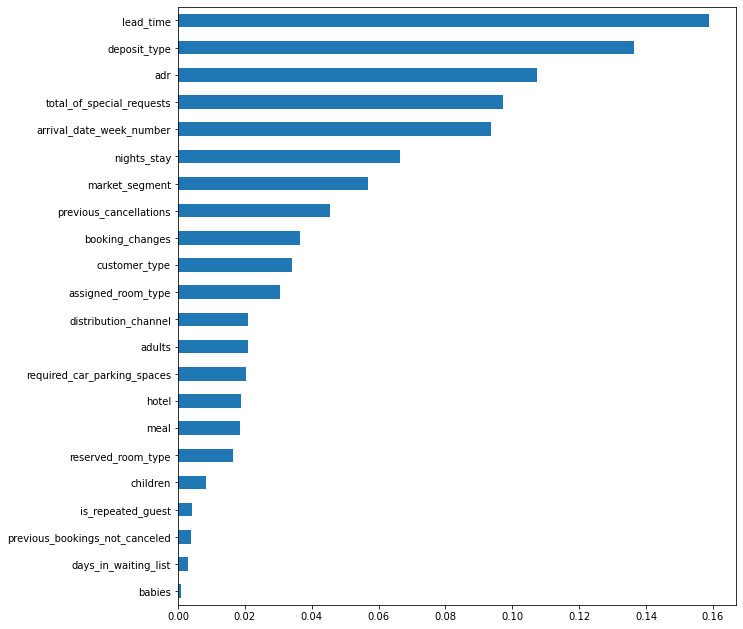

In [0]:
model = pipeline.named_steps['randomforestclassifier']
wrangle = pipeline.named_steps['wrangledata']
importances = pd.Series(model.feature_importances_, wrangle.columns_)

plt.figure(figsize=(10, len(wrangle.columns_) / 2))
importances.sort_values().plot.barh();

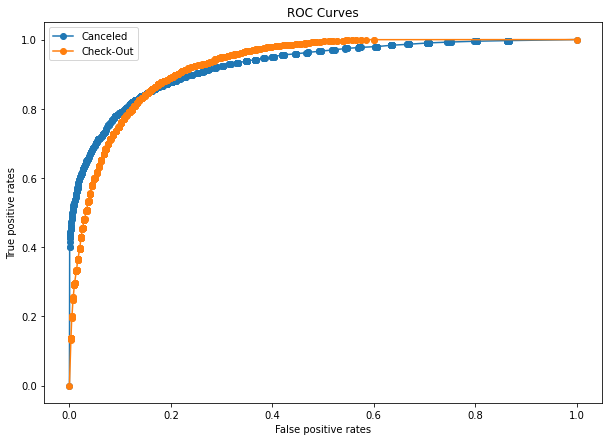

In [0]:
tools.ROCcurves(y_val, X_val, pipeline, model.classes_)

In [0]:
counts = y_train.value_counts()
counts[0] / counts[1]

1.657207583164421

In [0]:
from xgboost import XGBClassifier

In [0]:


xg_pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            SMOTE(random_state=42),
                            XGBClassifier(random_state=42,
                                          n_estimators=1500,
                                          max_depth=8,
                                          learning_rate=0.5,
                                          scale_pos_weight=1.67,
                                          n_jobs=-1))

tools.tryModel(xg_pipeline, X_train, y_train, X_val, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.25663346196416 %
Validate score = 85.40831588393658 %




'Confusion Matrix'

,Check-Out,Canceled
Check-Out,9429,996
Canceled,1443,4847


'Metrics'

,precision,recall,f1-score
Check-Out,0.867274,0.904460,0.885477
Canceled,0.829540,0.770588,0.798978


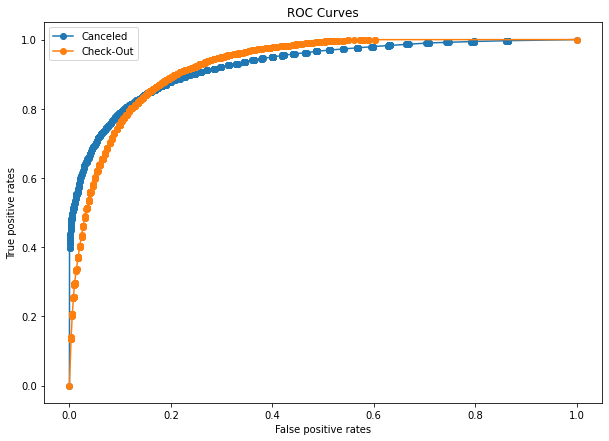

In [0]:
model = xg_pipeline.named_steps['xgbclassifier']
tools.ROCcurves(y_val, X_val, pipeline, model.classes_)

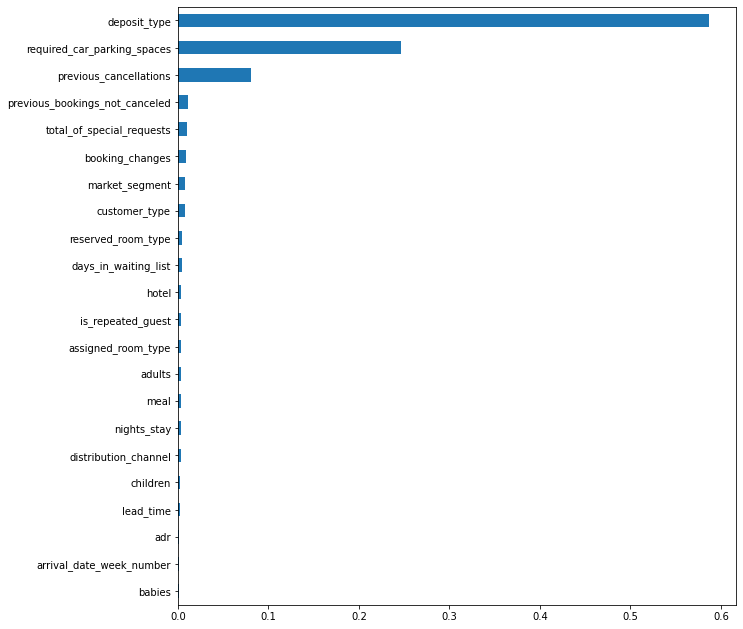

In [0]:
wrangle = xg_pipeline.named_steps['wrangledata']
importances = pd.Series(model.feature_importances_, wrangle.columns_)

plt.figure(figsize=(10, len(wrangle.columns_) / 2))
importances.sort_values().plot.barh();

In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

xg_pipeline = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                            ce.OrdinalEncoder(),
                            SimpleImputer(),
                            SMOTE(random_state=42),
                            SelectKBest(score_func=chi2),
                            XGBClassifier(random_state=42,
                                          n_estimators=1500,
                                          max_depth=8,
                                          learning_rate=0.5,
                                          scale_pos_weight=1.67,
                                          n_jobs=-1))

params = {'selectkbest__k': range(1, len(wrangle.columns_))}
search = GridSearchCV(xg_pipeline, params, scoring='recall', n_jobs=-1, verbose=10,
                      cv=3)
search.fit(X_train, y_train_enc)

pl = search.best_estimator_
selector = pl.named_steps['selectkbest']
wrang = pl.named_steps['wrangledata']
print(f'Features:\n{wrang.columns_[selector.get_support()]}')
print(f'Best score {search.best_score_}\nParameters: {search.best_params_} %')


Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 34.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed: 79.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Features:
Index(['hotel', 'lead_time', 'arrival_date_week_number', 'adults', 'babies',
       'meal', 'market_segment', 'distribution_channel', 'is_repeated_guest',
       'previous_cancellations', 'previous_bookings_not_canceled',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'nights_stay'],
      dtype='object')
Best score 0.7757640793291204
Parameters: {'selectkbest__k': 21} %


In [79]:
features = wrang.columns_[selector.get_support()]

xg_pipeline1 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                                tools.selectFeatures(features),
                            ce.OrdinalEncoder(),
                            SimpleImputer(strategy='median'),
                            SMOTE(random_state=42),
                            XGBClassifier(random_state=42,
                                          n_estimators=1500,
                                          max_depth=8,
                                          learning_rate=0.5,
                                          scale_pos_weight=1.67,
                                          n_jobs=-1))

y_val_enc = y_val == 'Canceled'
tools.tryModel(xg_pipeline1, X_train, y_train_enc, X_val, y_val_enc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.18483951060456 %
Validate score = 84.58271014059228 %




'Confusion Matrix'

,False,True
False,9166,1259
True,1318,4972


'Metrics'

,precision,recall,f1-score
False,0.874285,0.879233,0.876752
True,0.797946,0.790461,0.794186


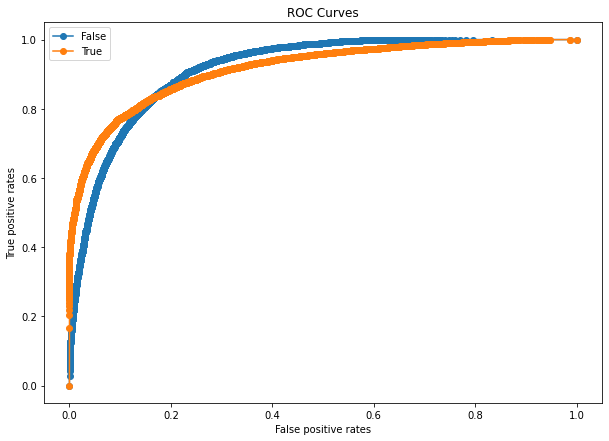

In [80]:
model = xg_pipeline1.named_steps['xgbclassifier']
tools.ROCcurves(y_val_enc, X_val, xg_pipeline1, classes=model.classes_)

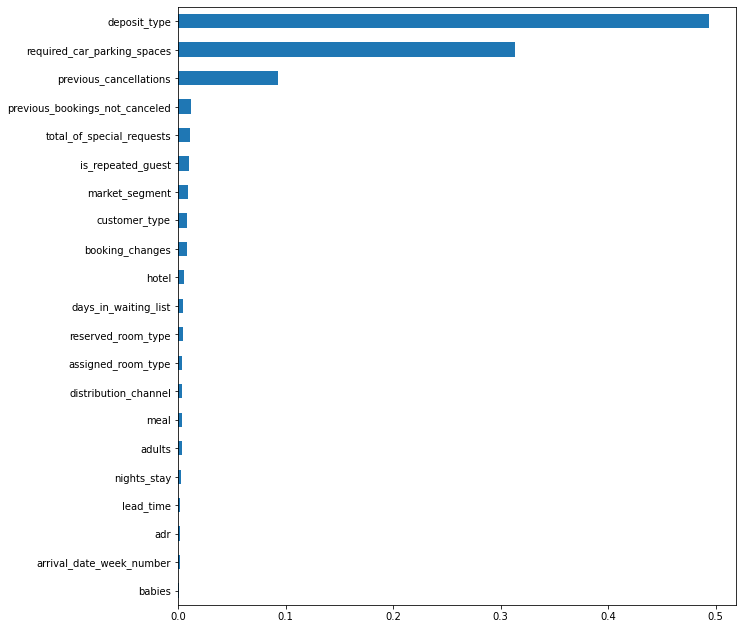

In [81]:
importances = pd.Series(model.feature_importances_, features)

plt.figure(figsize=(10, len(wrangle.columns_) / 2))
importances.sort_values().plot.barh();

In [76]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

     |████████████████████████████████| 112kB 2.9MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [91]:
transformers = make_pipeline(tools.wrangleData(max_cardinality=50),
                             tools.selectFeatures(features),
                             ce.OrdinalEncoder(),
                             SimpleImputer())

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

X_train_resample, y_train_resample = SMOTE(random_state=42).fit_sample(X_train_transformed,
                                                                       y_train_enc)

xgb_model = XGBClassifier(random_state=42,
                          n_estimators=1500,
                          max_depth=8,
                          learning_rate=0.5,
                          scale_pos_weight=1.67,
                          n_jobs=-1)

xgb_model.fit(X_train_resample, y_train_resample)

permuter = PermutationImportance(
    xgb_model,
    scoring='accuracy',
    random_state=42
)

permuter1 = PermutationImportance(
    xgb_model,
    scoring='recall',
    random_state=42
)

permuter.fit(X_val_transformed, y_val_enc)
permuter1.fit(X_val_transformed, y_val_enc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.5,
                                              max_delta_step=0, max_depth=8,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1500, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1,
                                              scale_pos_weight=1.67, seed=None,
                            

In [92]:
permute_scores = pd.Series(permuter.feature_importances_, features)
permute_scores.sort_values(ascending=False)

deposit_type                      0.097685
lead_time                         0.071876
total_of_special_requests         0.046461
adr                               0.043745
previous_cancellations            0.034077
market_segment                    0.028202
assigned_room_type                0.027018
arrival_date_week_number          0.025953
nights_stay                       0.021645
reserved_room_type                0.017936
customer_type                     0.017816
required_car_parking_spaces       0.014741
hotel                             0.009465
booking_changes                   0.007347
adults                            0.006605
previous_bookings_not_canceled    0.003984
meal                              0.002800
distribution_channel              0.001831
days_in_waiting_list              0.001041
is_repeated_guest                 0.000610
babies                            0.000108
dtype: float64

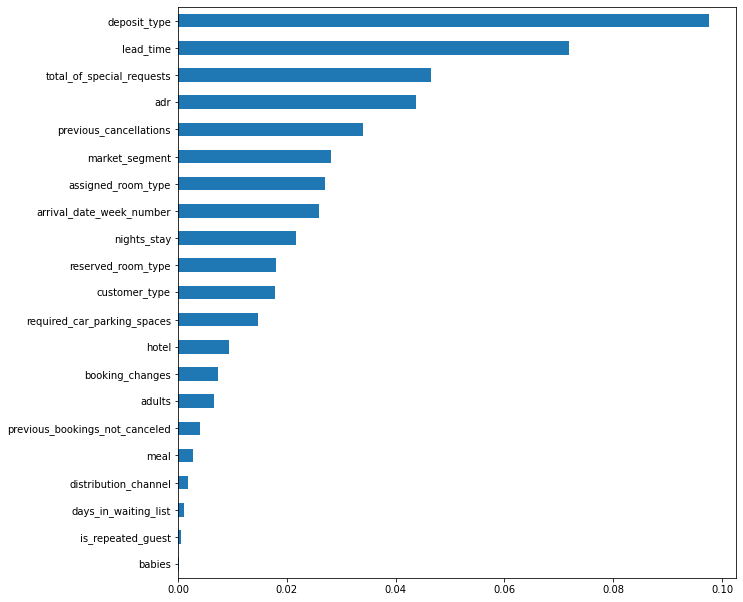

In [93]:
plt.figure(figsize=(10, len(features) / 2))
permute_scores.sort_values().plot.barh();

In [94]:
permute1_scores = pd.Series(permuter1.feature_importances_, features)
permute1_scores.sort_values(ascending=False)

assigned_room_type                0.126296
reserved_room_type                0.120700
deposit_type                      0.115771
adr                               0.111701
market_segment                    0.098824
lead_time                         0.091638
customer_type                     0.064324
arrival_date_week_number          0.051161
total_of_special_requests         0.037806
previous_cancellations            0.028839
nights_stay                       0.027822
required_car_parking_spaces       0.025246
meal                              0.015994
hotel                             0.012273
booking_changes                   0.012210
distribution_channel              0.010684
previous_bookings_not_canceled    0.009094
is_repeated_guest                 0.005501
adults                            0.003847
days_in_waiting_list              0.003402
babies                            0.000127
dtype: float64

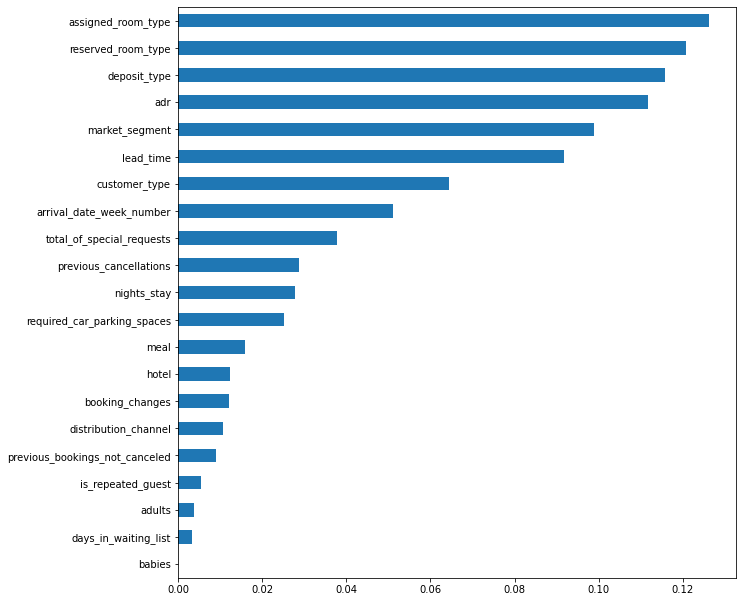

In [95]:
plt.figure(figsize=(10, len(features) / 2))
permute1_scores.sort_values().plot.barh();

In [104]:
refined_features = getFeatures(permute1_scores, 0.01)
refined_features

['hotel',
 'lead_time',
 'arrival_date_week_number',
 'meal',
 'market_segment',
 'distribution_channel',
 'previous_cancellations',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'nights_stay']

In [105]:
xg_pipeline2 = make_imb_pipeline(tools.wrangleData(max_cardinality=50),
                                tools.selectFeatures(refined_features),
                            ce.OrdinalEncoder(),
                            SimpleImputer(strategy='median'),
                            SMOTE(random_state=42),
                            XGBClassifier(random_state=42,
                                          n_estimators=1500,
                                          max_depth=8,
                                          learning_rate=0.5,
                                          scale_pos_weight=1.67,
                                          n_jobs=-1))

y_val_enc = y_val == 'Canceled'
tools.tryModel(xg_pipeline2, X_train, y_train_enc, X_val, y_val_enc)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)




Train score = 99.13548116904484 %
Validate score = 84.4092132814837 %




'Confusion Matrix'

,False,True
False,9151,1274
True,1332,4958


'Metrics'

,precision,recall,f1-score
False,0.872937,0.877794,0.875359
True,0.795571,0.788235,0.791886
